In [279]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import seaborn as sns

In [10]:
df = pd.read_csv("adult/adult.data", header=None)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', 'y']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [21]:
df.shape

(32561, 15)

In [142]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

## Train Models

In [97]:
ycol = "y"

fields_numeric = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
fields_categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country"]


fields_numeric1 = ["age", "capital-gain",  "hours-per-week"]
fields_numeric2 = [f for f in fields_numeric if f not in fields_numeric1]

fields_categorical1 = ["workclass", "education", "relationship", "race"]
fields_categorical2 = [f for f in fields_categorical if f not in fields_categorical1]

fields_all1 = fields_numeric1 + fields_categorical1
fields_all2 = fields_numeric2 + fields_categorical2

In [98]:
# segment into two populations by sex (M and F)

X = df[fields_all + ["sex"]]
y = df[ycol]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)


def obtain_classifier(X_train, X_test, y_train, y_test, fields_categorical, classifier):

    # Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
    categorical_transformer = OneHotEncoder()

    preprocessor = ColumnTransformer(
        transformers = [
            ("cat", categorical_transformer, fields_categorical)
        ]
    )
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print(classification_report(
        y_test,
        y_pred))
    
    return pipeline, y_pred


clf1, y_pred1 = obtain_classifier(X_train[fields_all1], X_test[fields_all1], y_train, y_test, fields_categorical1, LogisticRegression())
clf2, y_pred2 = obtain_classifier(X_train[fields_all2], X_test[fields_all2], y_train, y_test, fields_categorical2, RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      4942
        >50K       0.71      0.45      0.55      1571

    accuracy                           0.82      6513
   macro avg       0.78      0.69      0.72      6513
weighted avg       0.81      0.82      0.81      6513

              precision    recall  f1-score   support

       <=50K       0.86      0.91      0.88      4942
        >50K       0.64      0.52      0.57      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.71      0.73      6513
weighted avg       0.80      0.81      0.81      6513



In [99]:
# prepare files for HW

# id | Class | y | Test 1 | Test 2

df_hw = pd.DataFrame(X_test["sex"])
df_hw["Actual"] = pd.Series(y_test, index=df_hw.index)
df_hw["Test1"] = pd.Series(y_pred1, index=df_hw.index)
df_hw["Test2"] = pd.Series(y_pred2, index=df_hw.index)

print(df_hw.shape)
df_hw.head()

(6513, 4)


,sex,Actual,Test1,Test2
14160,Female,<=50K,<=50K,<=50K
27048,Female,<=50K,<=50K,>50K
28868,Male,>50K,>50K,>50K
5667,Female,<=50K,<=50K,<=50K
7827,Male,<=50K,<=50K,<=50K


In [109]:
df_hw.replace({" Female": 1, " Male": 2, ' <=50K': 0, ' >50K': 1}, inplace=True)

In [110]:
df_hw.to_csv("HW_adult.csv")

In [135]:
# Calculate 

def calculate_rates(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0][0]
    TP = cm[1][1]
    
    FN = cm[1][0]
    FP = cm[0][1]
    
    tpr = (TP) / (TP + FN)
    fnr = (FN) / (FN + TP)

    fpr = (FP) / (FP + TN)
    tnr = (TN) / (TN + FP)
        
    return tpr, tnr, fpr, fnr

print(" & ".join([str(round(x, 3)) for x in calculate_rates(df_hw.Actual, df_hw.Test1)]))

print(" & ".join([str(round(x, 3)) for x in calculate_rates(df_hw.Actual, df_hw.Test2)]))

def calculate_base_rates(df_slice):
    base_rate_1 = df_slice[df_slice.sex == 1].Actual.value_counts(normalize=True)[1]
    base_rate_2 = df_slice[df_slice.sex == 2].Actual.value_counts(normalize=True)[1]
    
    return base_rate_1, base_rate_2

print(calculate_base_rates(df_hw))

0.446 & 0.942 & 0.058 & 0.554
0.523 & 0.906 & 0.094 & 0.477
(0.10959548447789276, 0.30499202188283564)


In [117]:
y_test.value_counts()

 <=50K    4942
 >50K     1571
Name: y, dtype: int64

## Rand Score

In [328]:
from scipy.stats import beta
from  sklearn.metrics import adjusted_rand_score, rand_score

zero_label = " <=50K"
one_label = " >50K"

print(f"LR Rand Index {rand_score(y_test, y_pred1)}")
# Count the positive and negative predictions
positive_count = np.sum(y_pred1 == one_label)
negative_count = np.sum(y_pred1 == zero_label)

# Choose a prior distribution for the prevalence (e.g., a non-informative beta prior)
prior_alpha = 1
prior_beta = 1

# Update the prior distribution based on the observed positive and negative counts
posterior_alpha = prior_alpha + positive_count
posterior_beta = prior_beta + negative_count

# Estimate the prevalence using the mean of the posterior distribution
prevalence = posterior_alpha / (posterior_alpha + posterior_beta)

# You can also calculate a credible interval (e.g., 95% interval) for the prevalence
credible_interval = beta(posterior_alpha, posterior_beta).interval(0.95)

print(f"Estimated prevalence: {prevalence:.3f}")
print(f"95% credible interval: ({credible_interval[0]:.3f}, {credible_interval[1]:.3f})")



print(f" Rf Rand Index {rand_score(y_test, y_pred2)}")

# Count the positive and negative predictions
positive_count = np.sum(y_pred2 == one_label)
negative_count = np.sum(y_pred2 == zero_label)

# Choose a prior distribution for the prevalence (e.g., a non-informative beta prior)
prior_alpha = 1
prior_beta = 1

# Update the prior distribution based on the observed positive and negative counts
posterior_alpha = prior_alpha + positive_count
posterior_beta = prior_beta + negative_count

# Estimate the prevalence using the mean of the posterior distribution
prevalence = posterior_alpha / (posterior_alpha + posterior_beta)

# You can also calculate a credible interval (e.g., 95% interval) for the prevalence
credible_interval = beta(posterior_alpha, posterior_beta).interval(0.95)

print(f"Estimated prevalence: {prevalence:.3f}")
print(f"95% credible interval: ({credible_interval[0]:.3f}, {credible_interval[1]:.3f})")

LR Rand Index 0.7075830384213617
Estimated prevalence: 0.152
95% credible interval: (0.143, 0.161)
 Rf Rand Index 0.6962627381789058
Estimated prevalence: 0.198
95% credible interval: (0.188, 0.207)


## Streaming

In [233]:
# from online_hui_walter.latent_structure_analysis import latent_profiles
# from online_hui_walter.rolling_metrics import get_marginals, alpha1, alpha2, beta1, beta2
from river import stream


from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd 

import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [327]:

profiles = []
predictions = []

for i, sample in enumerate(stream.iter_pandas(X_test, y_test)):
    xi, yi = sample

    sample1 = [xi[x] for x in fields_all1]
    sample2 = [xi[x] for x in fields_all2]

    profiles.append(xi['sex'])
    predictions.append([clf1.predict(pd.DataFrame(xi, index=[0])), 
                        clf2.predict(pd.DataFrame(xi, index=[0])), yi])


In [334]:
def contingency_table(profiles, predictions):

    t = np.zeros((2,2,2))
    for i, prediction in enumerate(predictions):
        pop = 0 if profiles[i] == " Female" else 1
        t1, t2, t_true = prediction
        # print(pop, t1, t2, t_true)
        # input()
        t1 = t1[0]
        t2 = t2[0]
        if t1 == one_label and t2 == one_label:
            t[pop, 0,0] += 1 # a
        if t1 == one_label and t2 == zero_label:
            t[pop, 0,1] += 1 # b
        if t1 == zero_label and t2 == one_label:
            t[pop, 1,0] += 1 # c
        if t1 == zero_label and t2 == zero_label:
            t[pop, 1,1] += 1 #d
    return t

def get_marginals(table):
    output = []
    if table.shape != (2, 2, 2):
        raise Exception("More than two pops or tests, not implemented.")
    for i in range(2):
        colsums = table[i,:,:].sum(axis=1)
        rowsums = table[i,:,:].sum(axis=0)
        n = np.concatenate(table[i,:,:]).sum()
        flattened = table[i,:,:].ravel()
        # a, b, c, d, e, f, g, h, n
        # a, b ,c, d, g, h, e, f, n <--
        output.append(list(flattened) + list(colsums) + list(rowsums) + [n])
    return output

def beta1(d1, d2, e1, e2, f1, f2, h1, h2, n1, n2, F):
    # numerator = (g1*e2-e1*g2)/(n1*n2) - d1/n1  + d2/n2 - F
    numerator = (f1*h2 - h1*f2)/(n1*n2) + (d2/n2) - (d1/n1) + F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def beta2(d1, d2, g1, g2, f1, f2, h1, h2, n1, n2, F):
    # numerator = (g2*e1 - e2* g1)/(n1*n2) - d1/n1 + d2/n2 - F
    numerator = (f2*h1 - h2*f1)/(n1*n2) + (d2/n2) - (d1/n1) + F
    denominator = 2 * (g2/n2 - g1/n1)
    # denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator


def alpha1(a1, a2, e1, e2, g1, g2, n1, n2, F):
    # numerator = (f1 * h2 - h1 * f2)/(n1 * n2) + a2/n2 - a1/n1 + F
    numerator = (g1*e2 - e1*g2)/(n1*n2) + a2/n2 - a1/n1 + F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def alpha2(a1, a2, e1, e2, g1, g2, n1, n2, F):
    # numerator = (f2*h1-h2*f1)/(n1*n2) + a2/n2 - a1/n1 - F
    numerator = (g2*e1 - e2*g1)/(n1*n2) + a2/n2 - a1/n1 + F
    # denominator = 2 * (e2/n2 - g1/n1)
    denominator = 2 * (g2/n2 - g1/n1)
    return numerator/denominator


def get_F(a1, a2, e1, e2, g1, g2, n1, n2):
    b = (g1 * e2 - g2 * e1)/ (n1*n2) + a1/n1 - a2/n2
    a = (g1/n1 - g2/n2)
    c = (a1 * e2 - a2 * e1) / (n1 * n2)
    return np.sqrt(b**2 - 4 * a * c)

def get_theta(x, a1, a2, e1, e2, g1, g2, n1, n2, F):
    a = (e1/n1 - e2/n2)
    b = (g1/n1 - g2/n2)
    c = a2/n2 - a1/n1
    return 1/2 - (x * a + x * b + c)/(2*F)

def get_metrics(table):
    pop1, pop2 = get_marginals(table)
    # a1, b1, c1, d1, e1, f1, g1, h1, n1 = pop1
    # a2, b2, c2, d2, e2, f2, g2, h2, n2 = pop2
    a1, b1 , c1, d1, g1, h1, e1, f1, n1 = pop1
    a2, b2 , c2, d2, g2, h2, e2, f2, n2 = pop2
    F = get_F(a1, a2, e1, e2, g1, g2, n1, n2)
    theta1 = get_theta(g1/n1, a1, a2, e1, e2, g1, g2, n1, n2, F)
    theta2 = get_theta(g2/n2, a1, a2, e1, e2, g1, g2, n1, n2, F)
    # b1 = beta1(d1, d2, e1, e2, g1, g2, n1, n2, F)
    b1 = beta1(d1, d2, e1, e2, f1, f2, h1, h2, n1, n2, F)
    # b2 = beta2(d1, d2, e1, e2, g1, g2, n1, n2, F)
    b2 = beta2(d1, d2, g1, g2, f1, f2, h1, h2, n1, n2, F)
    
    # a1 = alpha1(a1, a2, e1, e2, f1, f2, h1, h2, n1, n2, F)
    a1 = alpha1(a1, a2, e1, e2, g1, g2, n1, n2, F)
    a2 = alpha2(a1, a2, e1, e2, g1, g2, n1, n2, F)
    return theta1, theta2, a1, a2, b1, b2

ts = []
for i in range(len(predictions)+1):
    t = contingency_table(profiles, predictions[:i])
    ts.append(get_metrics(t))


In [339]:
get_marginals(t)

[[86.0, 37.0, 72.0, 1931.0, 123.0, 2003.0, 158.0, 1968.0, 2126.0],
 [668.0, 198.0, 461.0, 3060.0, 866.0, 3521.0, 1129.0, 3258.0, 4387.0]]

In [335]:
t

array([[[  86.,   37.],
        [  72., 1931.]],

       [[ 668.,  198.],
        [ 461., 3060.]]])

In [336]:
df_tmp = pd.DataFrame({"population": profiles, "t1": [p[0][0] for p in predictions],
                       "t2": [p[1][0] for p in predictions]})
df_tmp.head()

,population,t1,t2
0,Female,<=50K,<=50K
1,Female,<=50K,>50K
2,Male,>50K,>50K
3,Female,<=50K,<=50K
4,Male,<=50K,<=50K


In [337]:
df_tmp[df_tmp.population == " Female"].groupby(["t1","t2"]).size()

t1      t2    
 <=50K   <=50K    1931
         >50K       72
 >50K    <=50K      37
         >50K       86
dtype: int64

ba1 (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0)
ba2 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0)


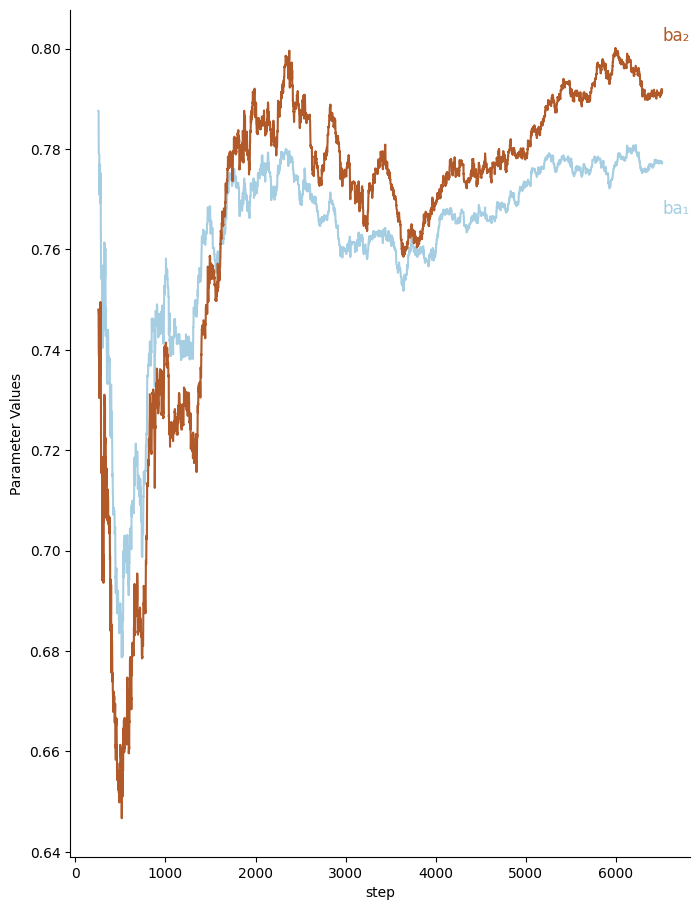

In [340]:

k = 255
theta1_timeseries = [t[0] if t[0] != np.nan else 0 for t in ts][k:]
theta2_timeseries = [t[1] if t[1] != np.nan else 0 for t in ts][k:]

alpha1_timeseries = [t[2] if t[2] != np.nan else 0 for t in ts][k:]
alpha2_timeseries = [t[3] if t[3] != np.nan else 0 for t in ts][k:]

beta1_timeseries = [t[4] if t[4] != np.nan else 0 for t in ts][k:]
beta2_timeseries = [t[5] if t[5] != np.nan else 0 for t in ts][k:]

tnr1 = (1 - np.asarray(alpha1_timeseries))
tnr2 = (1 - np.asarray(alpha2_timeseries))
tpr1 = (1 - np.asarray(beta1_timeseries))
tpr2 = (1 - np.asarray(beta2_timeseries))

ba1 = (tpr1 + tnr1)/2
ba2 = (tpr2 + tnr2)/2


df = pd.DataFrame(
    {
        "step": [i for i in range(len(ts))][k:],
        "theta1": theta1_timeseries,
        "theta2": theta2_timeseries,
        "alpha1": alpha1_timeseries,
        "alpha2": alpha2_timeseries,
        "beta1": beta1_timeseries,
        "beta2": beta2_timeseries,
        "ba1" : ba1,
        "ba2" : ba2
    }
)

def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    for column in y:    
        positions[column] = df[column].values[-1]  #- 1.5    

    def push():
        """
        ...by puting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 0.02:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .01
                            positions[column2] += .01
                        else:
                            positions[column1] += .01
                            positions[column2] -= .01
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

x = 'step'
#y = ['theta1', 'theta2', 'alpha1',
#      'alpha2', 'beta1', 'beta2']
y = ["ba1", "ba2"]
leg = [
    #"$\theta_1$", "$\theta_1$", "$\alpha_1$", "$\alpha_2$", "$\beta_1$", "$\beta_2$"
    "ba₁",
    "ba₂",
    "θ₂",
    "θ₁",
    "α₁",
    "α₂",
    "β₁",
    "β₂",
]
positions = legend_positions(df, y)

f, ax = plt.subplots(figsize=(8,11))        
cmap = plt.cm.get_cmap('Paired', len(y))

for i, (column, position) in enumerate(positions.items()):

    # Get a color
    color = cmap(float(i)/len(positions))
    # Plot each line separatly so we can be explicit about color
    ax = df.plot(x=x, y=column, legend=False, ax=ax, color=color)

    
    print(y[i], color)
    # Add the text to the right
    plt.text(
        df[x][df[column].last_valid_index()] + 0.5,
        position, leg[i], fontsize=12,
        color=color # Same color as line
    )

# Thetas

ax.set_ylabel('Parameter Values')
sns.despine()

In [341]:
print(np.mean(ba1))
print(np.mean(ba2))

0.7625114842806374
0.7668511584112411
